In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import libraries 
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import wave
from sklearn.metrics import confusion_matrix
import IPython.display as ipd 
import os
import pickle
import sys
import warnings
from tensorflow.python.keras import optimizers
import pickle
# import pyaudio
# import h5py

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
RAVDESS = "data/RAVDESS/"

In [3]:
# RAVDESS data handling
# 1.Get data of RAVESS

RAVDESS_list = os.listdir(RAVDESS)
RAVDESS_list.sort()

emotion = []
gender = []
path = []

for i in RAVDESS_list:
    if i != '.DS_Store':
        folder_name = os.listdir(RAVDESS + i)
        for f in folder_name:
            part = f.split('.')[0].split('-')
            emotion.append(int(part[2]))
            temp = int(part[6])
            if temp%2 == 0:
                temp = "female"
            else:
                temp = "male"
            gender.append(temp)
            path.append(RAVDESS + i + '/' + f)
        
RAVDESS_data_frame = pd.DataFrame(emotion)
RAVDESS_data_frame = RAVDESS_data_frame.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry'
                                                 , 6:'fear', 7:'disgust', 8:'surprise'})
RAVDESS_data_frame = pd.concat([pd.DataFrame(gender),RAVDESS_data_frame],axis=1)
RAVDESS_data_frame.columns = ['gender','emotion']
RAVDESS_data_frame['labels'] = RAVDESS_data_frame.gender + '_' + RAVDESS_data_frame.emotion
RAVDESS_data_frame['source'] = 'RAVDESS'  
RAVDESS_data_frame = pd.concat([RAVDESS_data_frame,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVDESS_data_frame = RAVDESS_data_frame.drop(['gender', 'emotion'], axis=1)
print(RAVDESS_data_frame.labels.value_counts())
RAVDESS_data_frame.head()
RAVDESS_data_frame.to_csv("Data_path.csv",index=False)

male_surprise      96
male_angry         96
male_fear          96
male_disgust       96
male_sad           96
male_happy         96
male_calm          96
female_fear        96
female_angry       96
female_sad         96
female_disgust     96
female_surprise    96
female_happy       96
female_calm        96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64


154505
44100


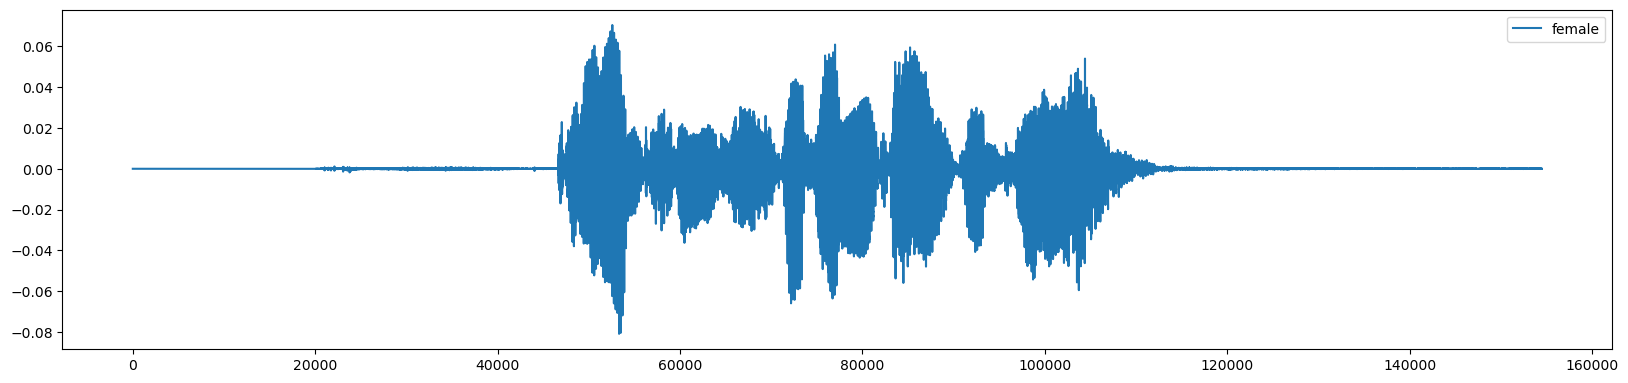

In [4]:
# Source - RAVDESS; Gender - Female; Emotion - happy 
path = RAVDESS + "Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',sr=22050*2)
print(len(X))
print(sample_rate)
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(X, label='female')
plt.legend()

299
265


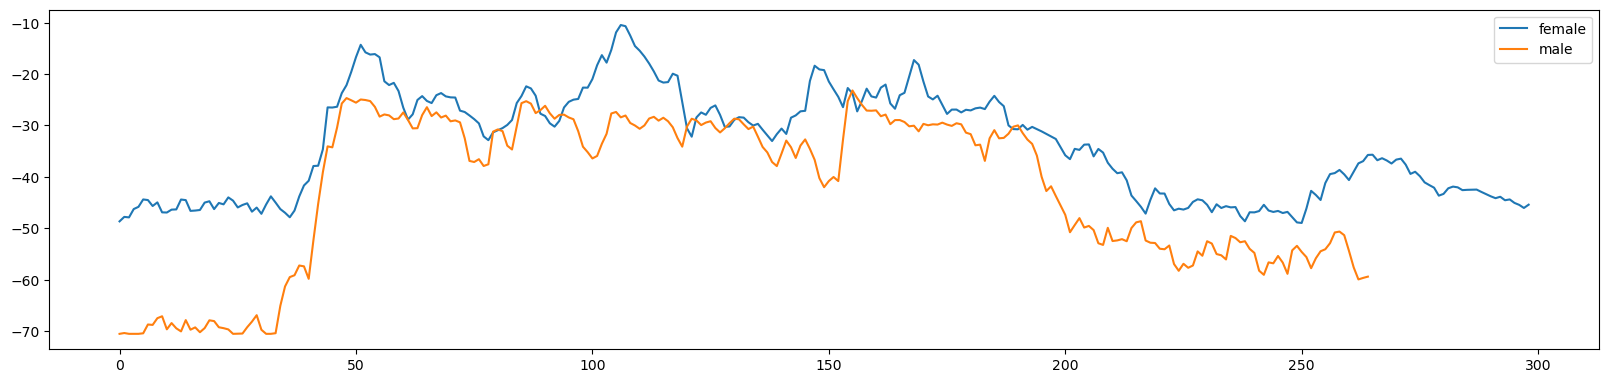

In [5]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = RAVDESS + "Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=6,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = RAVDESS + "Actor_09/03-01-05-01-01-01-09.wav" 
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=6,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [6]:
ref = pd.read_csv("Data_path.csv")
ref.head()

,labels,source,path
0,male_surprise,RAVDESS,data/RAVDESS/Actor_01/03-01-08-02-02-01-01.wav
1,male_surprise,RAVDESS,data/RAVDESS/Actor_01/03-01-08-01-01-01-01.wav
2,male_angry,RAVDESS,data/RAVDESS/Actor_01/03-01-05-01-02-01-01.wav
3,male_fear,RAVDESS,data/RAVDESS/Actor_01/03-01-06-01-02-02-01.wav
4,male_fear,RAVDESS,data/RAVDESS/Actor_01/03-01-06-02-01-02-01.wav


In [7]:
data_frame = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    data_frame.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(data_frame))
data_frame.head()

1440


,feature
0,"[-61.862686, -61.862686, -61.862686, -61.86268..."
1,"[-61.508343, -61.508343, -61.508343, -61.50834..."
2,"[-56.16543, -56.166897, -56.158165, -54.663876..."
3,"[-63.523846, -63.523846, -63.523846, -63.52384..."
4,"[-44.64032, -44.249107, -43.99614, -44.132103,..."


In [8]:
data_frame = pd.concat([ref,pd.DataFrame(data_frame['feature'].values.tolist())],axis=1)
data_frame[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_surprise,RAVDESS,data/RAVDESS/Actor_01/03-01-08-02-02-01-01.wav,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,...,-61.862686,-61.862686,-61.761757,-60.348843,-60.160908,-61.384720,-60.519608,-61.496365,-61.862686,-61.146397
1,male_surprise,RAVDESS,data/RAVDESS/Actor_01/03-01-08-01-01-01-01.wav,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,...,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343
2,male_angry,RAVDESS,data/RAVDESS/Actor_01/03-01-05-01-02-01-01.wav,-56.165428,-56.166897,-56.158165,-54.663876,-55.167160,-56.157265,-56.157265,...,-55.155525,-56.157265,-56.157265,-56.157265,-55.844578,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265
3,male_fear,RAVDESS,data/RAVDESS/Actor_01/03-01-06-01-02-02-01.wav,-63.523846,-63.523846,-63.523846,-63.523846,-63.523846,-63.377724,-61.596287,...,-39.336967,-39.848244,-40.466457,-40.448551,-42.883549,-43.368042,-46.280754,-48.274254,-49.644100,-49.611149
4,male_fear,RAVDESS,data/RAVDESS/Actor_01/03-01-06-02-01-02-01.wav,-44.640320,-44.249107,-43.996140,-44.132103,-44.267784,-44.346001,-44.142799,...,-32.988121,-33.477657,-33.367558,-32.960381,-31.951490,-31.074728,-31.176334,-30.759197,-22.924541,-15.743834


In [9]:
data_frame = data_frame.fillna(0)
print(data_frame.shape)
data_frame[:5]

(1440, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_surprise,RAVDESS,data/RAVDESS/Actor_01/03-01-08-02-02-01-01.wav,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,-61.862686,...,-61.862686,-61.862686,-61.761757,-60.348843,-60.160908,-61.384720,-60.519608,-61.496365,-61.862686,-61.146397
1,male_surprise,RAVDESS,data/RAVDESS/Actor_01/03-01-08-01-01-01-01.wav,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,...,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343,-61.508343
2,male_angry,RAVDESS,data/RAVDESS/Actor_01/03-01-05-01-02-01-01.wav,-56.165428,-56.166897,-56.158165,-54.663876,-55.167160,-56.157265,-56.157265,...,-55.155525,-56.157265,-56.157265,-56.157265,-55.844578,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265
3,male_fear,RAVDESS,data/RAVDESS/Actor_01/03-01-06-01-02-02-01.wav,-63.523846,-63.523846,-63.523846,-63.523846,-63.523846,-63.377724,-61.596287,...,-39.336967,-39.848244,-40.466457,-40.448551,-42.883549,-43.368042,-46.280754,-48.274254,-49.644100,-49.611149
4,male_fear,RAVDESS,data/RAVDESS/Actor_01/03-01-06-02-01-02-01.wav,-44.640320,-44.249107,-43.996140,-44.132103,-44.267784,-44.346001,-44.142799,...,-32.988121,-33.477657,-33.367558,-32.960381,-31.951490,-31.074728,-31.176334,-30.759197,-22.924541,-15.743834


In [10]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(data_frame.drop(['path','labels','source'],axis=1)
                                                    , data_frame.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )
# Check the dataset now 
X_train.head()
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
168,-39.460396,-42.556416,-45.279720,-45.535892,-45.075871,-45.133282,-44.699333,-45.068977,-45.376606,-45.128670,...,-17.034380,-16.539120,-15.113464,-18.174229,-21.630619,-22.855436,-21.752399,-21.372486,-18.433479,-10.575611
605,-32.765850,-33.019241,-36.096096,-35.931705,-35.872089,-35.929192,-34.584915,-35.861523,-36.118462,-37.410191,...,-45.422733,-45.210838,-46.085148,-45.995770,-46.170174,-46.866837,-47.589802,-48.592567,-48.852139,-50.622341
548,-45.752823,-43.117104,-42.710346,-43.666416,-42.721718,-41.825596,-41.396843,-42.239700,-43.496284,-42.738041,...,-47.221638,-46.464878,-46.059044,-47.506260,-47.777237,-46.830345,-47.135735,-47.179214,-46.294804,-46.075893
65,-63.462448,-63.462448,-63.462448,-63.462448,-63.462448,-63.462448,-63.462448,-63.462448,-63.462448,-63.462448,...,-50.296551,-48.890568,-49.612370,-50.704182,-52.735420,-53.797127,-54.055641,-54.222153,-56.528095,-60.617058
628,-62.672295,-63.258102,-60.447201,-57.983818,-55.702560,-56.273273,-57.004848,-56.641201,-57.897377,-58.417557,...,-55.447197,-56.076298,-54.481071,-53.793125,-54.813164,-53.951591,-53.331997,-52.543118,-51.992313,-53.856441


In [11]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train.head()
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
168,1.947226,1.542935,1.254729,1.217751,1.263129,1.247521,1.278120,1.226769,1.184699,1.207190,...,2.466174,2.529588,2.657964,2.425395,2.139801,2.064989,2.185018,2.230284,2.245118,2.554261
605,2.735111,2.682427,2.373862,2.383284,2.374310,2.357154,2.483045,2.319481,2.285308,2.123389,...,0.025529,0.066212,0.011022,0.042341,0.042137,0.000935,-0.034979,-0.098051,-0.158111,-0.291628
548,1.206668,1.475944,1.567837,1.444624,1.547348,1.646292,1.671544,1.562539,1.408232,1.490962,...,-0.129129,-0.041531,0.013253,-0.087040,-0.095236,0.004072,0.004035,0.022843,0.043931,0.031461
65,-0.877587,-0.954898,-0.961051,-0.957760,-0.956699,-0.962219,-0.957119,-0.956112,-0.965345,-0.969067,...,-0.393490,-0.249938,-0.290426,-0.360958,-0.519066,-0.594802,-0.590536,-0.579591,-0.764551,-1.001895
628,-0.784593,-0.930483,-0.593608,-0.292890,-0.019841,-0.095502,-0.187829,-0.146587,-0.303770,-0.370228,...,-0.836309,-0.867311,-0.706521,-0.625542,-0.696673,-0.608080,-0.528359,-0.435971,-0.406201,-0.521457


In [12]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
# print(y_train[0:10])
# print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1080, 216)
['female_angry' 'female_calm' 'female_disgust' 'female_fear'
 'female_happy' 'female_neutral' 'female_sad' 'female_surprise'
 'male_angry' 'male_calm' 'male_disgust' 'male_fear' 'male_happy'
 'male_neutral' 'male_sad' 'male_surprise']


In [13]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 216, 1)